# fastbook 04_mnist_basics
> not done

- toc:false
- branch: master
- badges: false
- comments: false 
- author: 최서연
- categories: [MNIST]

ref: https://github.com/fastai/fastbook

In [38]:
!pip install -Uqq fastbook

In [39]:
import fastbook
fastbook.setup_book()
from fastai.vision.all import *
from fastbook import *
matplotlib.rc('image', cmap='Greys')

## Introduction

- We'll explain stochastic gradient descent (SGD), the mechanism for learning by updating weights automatically.
- We'll discuss the choice of a loss function for our basic classification task, and the role of mini-batches.
- We'll also describe the math that a basic neural network is actually doing.
- Finally, we'll put all these pieces together.

## End sidebar

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
Path.BASE_PATH = path

In [4]:
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

In [5]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

Let's take a look in one of these folders (using sorted to ensure we all get the same order of file

In [6]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

Let’s take a look at one now. Here’s an image of a handwritten number 3, taken from the famous MNIST dataset of handwritten numbers:

In [7]:
im3_path=threes[1]
im3=Image.open(im3_path)
im3

Here we are using the *Image* class from the *Python Imaging Library (PIL)*, which is the most widely used Python package for opening, manipulating, and viewing images.

In [8]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

NumPy indexes from top to bottom and left to right, so this section is located in the top-left corner of the image.

Here's the same thing as a PyTorch tensor:

In [9]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [10]:
im3_t=tensor(im3)
df=pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


- You can see that the background **white pixels are stored as the number 0**, **black is the number 255**, and **shades of gray are between the two**. 
-  The entire image contains 28 pixels across and 28 pixels down, for a total of 784 pixels.

## Pixel Similarity

In [11]:
array(im3)[4:10,4:10]/255

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.11372549],
       [0.        , 0.        , 0.        , 0.18823529, 0.65098039,
        0.87843137],
       [0.        , 0.36470588, 0.95686275, 0.97647059, 0.99215686,
        0.73333333],
       [0.        , 0.41960784, 0.99215686, 0.99215686, 0.90196078,
        0.18823529],
       [0.        , 0.01176471, 0.07843137, 0.07843137, 0.05882353,
        0.        ]])

In [12]:
three_tensors=[tensor(Image.open(i)) for i in threes]
seven_tensors=[tensor(Image.open(i)) for i in sevens]

In [13]:
len(three_tensors),len(seven_tensors)

(6131, 6265)

Since we now *have tensors* (which Jupyter by default will print as values), rather than PIL images (which Jupyter by default will display as images), we need to use fastai's show_image function to display it:`

<AxesSubplot:>

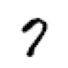

In [14]:
show_image(seven_tensors[3])

- For every pixel position, we want to compute the average over all the images of the intensity of that pixel. 
    - 모든 픽셀 위치에서 해당 픽셀 강도의 모든 이미지에 대한 평균을 계산하기 위해서 
- To do this we first combine all the images in this list into a single three-dimensional tensor. 
    - 우선 이 리스트의 모든 이미지를 단일 3차원 텐서로 결합한다.
- The most common way to describe such a tensor is to call it a rank-3 tensor. 
- We often need to stack up individual tensors in a collection into a single tensor. 

Generally when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255 here:

In [15]:
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255

In [16]:
stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

There is nothing specifically about this tensor that says that the first axis is the number of images, the second is the height, and the third is the width

In [17]:
len(stacked_sevens.shape)

3

> important: rank is the number of axes or dimensions in a tensor; shape is the size of each axis of a tensor.

We can also get a tensor's rank directly with ndim:

In [18]:
stacked_sevens.ndim

3

for every pixel position, this will compute the average of that pixel over all images. 

The result will be one value for every pixel position, or a single image. Here it is:

<AxesSubplot:>

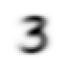

In [19]:
mean3=stacked_threes.mean(0)
show_image(mean3)

<AxesSubplot:>

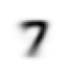

In [20]:
mean7=stacked_sevens.mean(0)
show_image(mean7)

<AxesSubplot:>

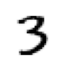

In [21]:
a_3 = stacked_threes[1]
show_image(a_3)

<AxesSubplot:>

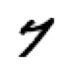

In [22]:
a_7 = stacked_sevens[1]
show_image(a_7)

<AxesSubplot:>

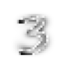

In [23]:
show_image(abs(a_3-mean3))

- We can't just add up the differences between the pixels of this image and the ideal digit. 
- Some differences will be positive while others will be negative, and these differences will cancel out, resulting in a situation where an image that is too dark in some places and too light in others might be shown as having zero total differences from the ideal.
- That would be misleading!

1. Take the mean of the *absolute value* of differences (absolute value is the function that replaces negative values with positive values). This is called the *mean absolute difference* or L1 norm
2. Take the mean of the *square* of differences (which makes everything positive) and then take the *square root* (which undoes the squaring). This is called the root mean *squared error (RMSE)* or L2 norm.

In [24]:
dist_3_abs=(a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3-mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [25]:
dist_7_abs=(a_7 - mean7).abs().mean()
dist_7_sqr = ((a_7-mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1304), tensor(0.2585))

- In both cases, the distance between our 3 and the "ideal" 3 is less than the distance to the ideal 7. 
- So our simple model will give the right prediction in this case.

PyTorch already provides both of these as loss functions. You'll find these inside `torch.nn.functional`, which the PyTorch team recommends importing as F (and is available by default under that name in fastai):

In [26]:
F.l1_loss(a_3.float(),mean3), F.mse_loss(a_3,mean3).sqrt()

(tensor(0.1114), tensor(0.2021))

In [27]:
F.l1_loss(a_7.float(),mean7), F.mse_loss(a_7,mean7).sqrt()

(tensor(0.1304), tensor(0.2585))

Here mse stands for mean squared error, and l1 refers to the standard mathematical jargon for mean absolute value (in math it's called the L1 norm).

## Computing Metrics Using Broadcasting

In [28]:
valid_3_tens = torch.stack([tensor(Image.open(i)) for i in (path/'valid'/'3').ls()]).float()/255
valid_7_tens = torch.stack([tensor(Image.open(i)) for i in (path/'valid'/'7').ls()]).float()/255
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [29]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))

In [30]:
mnist_distance(a_3,mean3)

tensor(0.1114)

This is the same value we previously calculated for the distance between these two images, the ideal 3 mean3 and the arbitrary sample 3 a_3, which are both single-image tensors with a shape of [28,28].

In [31]:
valid_3_dist=mnist_distance(valid_3_tens,mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1421, 0.1246, 0.1330,  ..., 0.1656, 0.1222, 0.1477]),
 torch.Size([1010]))

PyTorch treats mean3, a rank-2 tensor representing a single image, as if it were 1,010 copies of the same image, and then subtracts each of those copies from each 3 in our validation set.

In [32]:
valid_3_tens.shape, mean3.shape, (valid_3_tens-mean3).shape

(torch.Size([1010, 28, 28]), torch.Size([28, 28]), torch.Size([1010, 28, 28]))

- PyTorch doesn't actually copy mean3 1,010 times. It pretends it were a tensor of that shape, but doesn't actually allocate any additional memory
- It does the whole calculation in C (or, if you're using a GPU, in CUDA, the equivalent of C on the GPU), tens of thousands of times faster than pure Python (up to millions of times faster on a GPU!).

our function calls *mean((-1,-2))*. The tuple (-1,-2) represents a range of axes. In Python, `-1` refers to the last element, and `-2` refers to the second-to-last. So in this case, this tells PyTorch that we want to take the mean ranging over the values indexed by the last two axes of the tensor. The last two axes are the horizontal and vertical dimensions of an image. After taking the mean over the last two axes, we are left with just the first tensor axis, which indexes over our images, which is why our final size was (1010). In other words, for every image, we averaged the intensity of all the pixels in that image.

We can use mnist_distance to figure out whether an image is a 3 or not by using the following logic: **if the distance between the digit in question and the ideal 3 is less than the distance to the ideal 7, then it's a 3**. This function will automatically do broadcasting and be applied elementwise, just like all PyTorch functions and operators:

In [33]:
def is_3(x): return mnist_distance(x,mean3)<mnist_distance(x,mean7)

In [34]:
is_3(a_3),is_3(a_3).float()

(tensor(True), tensor(1.))

Note that when we convert the Boolean response to a float, **we get 1.0 for True and 0.0 for False**.

In [35]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [36]:
accuracy_3s=is_3(valid_3_tens).float().mean()
accuracy_7s = (1-is_3(valid_7_tens).float()).mean()
accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent (SGD)

we could instead look at each individual pixel and come up with a set of weights for each one, such that the highest weights are associated with those pixels most likely to be black for a particular category. 
- We want to find the specific values for the vector w that causes the result of our function to be high for those images that are actually 8s

Here are the steps that we are going to require, to turn this function into a machine learning classifier:
1. Initialize the weights. 
    - 가중치를 초기화한다.
        - We initialize the parameters to random values. 
2. For each image, use these weights to predict whether it appears to be a 3 or a 7.
    - 각 이미지에 대해 3이나 7로 나타나는지 예측하기 위해 가중치를 사용한다.
3. Based on these predictions, calculate how good the model is (its loss).
    - 이 예측을 바탕으로 모델이 얼마나 좋은지 즉, 손실을 계산한다.
        - We need some function that will return a number that is small if the performance of the model is good.
        - the standard approach is to treat a small loss as good, and a large loss as bad, although this is just a convention.
4. Calculate the gradient, which measures for each weight, how changing that weight would change the loss
    - 각 가중치를 측정하는 기울기를 계산하고, 가중치가 변경되면 손실은 어떻게 변화하는지 계산한다.
5. Step (that is, change) all the weights based on that calculation.
    - 계산에 따라 모든 가중치를 단계, 즉 변경한다.
6. Go back to the step 2, and repeat the process.
    - 2단계로 돌아가서 과정을 반복한다.
7. Iterate until you decide to stop the training process (for instance, because the model is good enough or you don't want to wait any longer).
    - 학습 과정을 중단하기로 결정할떄까지 반복한다.(모델이 충분히 좋거나 더이상 기다리기 싫을때)
        - Once we've decided how many epochs to train the model for (a few suggestions for this were given in the earlier list), we apply that decision.

- These seven steps, illustrated in <>, are the key to the training of all deep learning models.
- That deep learning turns out to rely entirely on these steps is extremely surprising and counterintuitive.

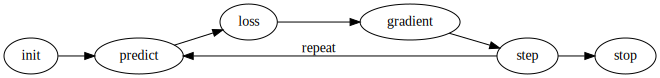

In [40]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

let's pretend that this is our loss function, and x is a weight parameter of the function:

In [41]:
def f(x): return x**2

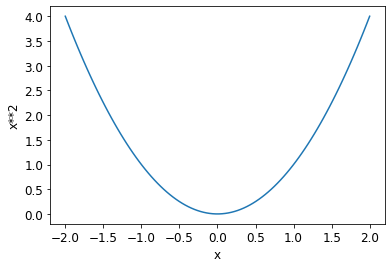

In [46]:
plot_function(f,'x','x**2')

The sequence of steps we described earlier starts by picking some random value for a parameter, and calculating the value of the loss:

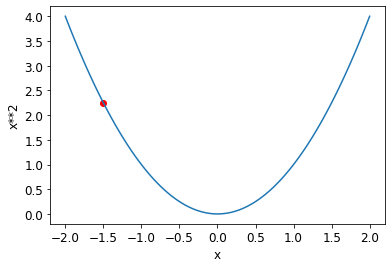

In [47]:
plot_function(f,'x','x**2')
plt.scatter(-1.5,f(-1.5),color='red')

We can change our weight by a little in the direction of the slope, calculate our loss and adjustment again, and repeat this a few times.
- 위와 같이 제시되었을때, 가중치를 기울기 방향으로 조금씩 바꾸어 손실과 조정을 반복해서 계산할 수 있다.(결국 (0,0)에 도달하게 될 것이다.)

## Calculating Gradients

- PyTorch is able to automatically compute the derivative of nearly any function!
- What's more, it does it very fast. 
- Most of the time, it will be at least as fast as any derivative function that you can create by hand.
- 파이토치는 어느 함수든 자동으로 계산하여 유도할 수 있으며, 빠르기까지 하다.

First, let's pick a tensor value which we want gradients at:

In [51]:
xt = tensor(3.0).requires_grad_()

Notice the special method` requires_grad_`? 
   - That's the magical incantation we use to tell PyTorch that we want to calculate gradients with respect to that variable at that value. 
   -  It is essentially tagging the variable, so PyTorch will remember to keep track of how to compute gradients of the other, direct calculations on it that you will ask for.
   - requires_grad_()는 변수에 태그하는 것이어서 파이토치가 나중에 우리가 직접 계산해달라고 해줄 다른 기울기를 계산하는 법의 추적을 가지고 있는 것이라 보면 된다.

Notice how PyTorch prints not just the value calculated, but also a note that it has a gradient function it'll be using to calculate our gradients when needed:

In [52]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [53]:
yt.backward()

The "backward" here refers to backpropagation, which is the name given to the process of calculating the derivative of each layer.
   - backward는 역전파를 가리키는데, 이건 각 층의 유도를 계산하는 과정에 주어진 이름이다.
   
This is called the "backward pass" of the network, as opposed to the "forward pass," which is where the activations are calculated. 

In [54]:
xt.grad

tensor(6.)

위는 우리가 입력한 xt 즉, 3과 f함수 **2가 적용되어 6이 나온 것.

Now we'll repeat the preceding steps, but with a vector argument for our function:

In [56]:
xt=tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

we'll **add sum** to our function so it can **take a vector** (i.e., a rank-1 tensor), and return a scalar (i.e., a rank-0 tensor):

In [57]:
def f(x): return (x**2).sum()

In [58]:
yt=f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [59]:
yt.backward()

In [60]:
xt.grad

tensor([ 6.,  8., 20.])

## Stepping With a Learning Rate

Nearly all approaches start with the basic idea of multiplying the gradient by some small number, called the **learning rate (LR).**
- The learning rate is often a number between 0.001 and 0.1, although it could be anything. 